In [1]:
# 02_feature_encoders.ipynb
# Feature extraction for multi-modal RICO UI embeddings

import json, random, torch, timm, pandas as pd, numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on:", device)

Running on: cpu


In [2]:
# Base directories
CORE_DIR = Path("data/rico_core")
SEM_DIR  = Path("data/rico_semantic_annotations")

# Build list of available (json, image) pairs in semantic
records = []
for p in sorted(SEM_DIR.glob("*.json")):
    img = p.with_suffix(".png")
    if not img.exists():
        img = p.with_suffix(".jpg")
    if img.exists():
        records.append({"id": p.stem, "img": str(img), "json": str(p)})

print(f"Found {len(records)} semantic UI screens")
df = pd.DataFrame(records)
df.head()

Found 66261 semantic UI screens


,id,img,json
0,0,data/rico_semantic_annotations/0.png,data/rico_semantic_annotations/0.json
1,1,data/rico_semantic_annotations/1.png,data/rico_semantic_annotations/1.json
2,10,data/rico_semantic_annotations/10.png,data/rico_semantic_annotations/10.json
3,100,data/rico_semantic_annotations/100.png,data/rico_semantic_annotations/100.json
4,1000,data/rico_semantic_annotations/1000.png,data/rico_semantic_annotations/1000.json


In [3]:
# Load pretrained tiny ViT from timm
import os
os.environ["HF_HUB_OFFLINE"] = "1"
os.environ["TORCH_HOME"] = str(Path.home() / ".cache" / "torch" / "hub")
vit = timm.create_model("vit_tiny_patch16_224.augreg_in21k_ft_in1k", pretrained=True)
vit.head = nn.Identity()
vit.eval().to(device)

from torchvision import transforms
vision_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

@torch.no_grad()
def extract_vit_features(img_path):
    img = Image.open(img_path).convert("RGB")
    x = vision_tf(img).unsqueeze(0).to(device)
    feat = vit(x)
    if isinstance(feat, tuple): feat = feat[0]
    return feat.squeeze().cpu().numpy()

In [4]:
import networkx as nx
from sklearn.preprocessing import OneHotEncoder

# Fit encoder on all possible component labels (from 24 categories)
LABELS = ['Toolbar','Text','Icon','Image','List Item','Button','Web View',
          'EditText','Tab','RecyclerView','Grid','Menu','ProgressBar','SeekBar',
          'CheckBox','RadioButton','Switch','Video','Map','Calendar','Dialog',
          'Advertisement','Keyboard','Unknown']
onehot = OneHotEncoder(handle_unknown="ignore").fit(np.array(LABELS).reshape(-1,1))

def parse_semantic_json(json_path):
    with open(json_path) as f:
        data = json.load(f)
    nodes, edges = [], []

    def walk(node, parent=None):
        if "bounds" in node:
            x1,y1,x2,y2 = node["bounds"]
            w, h = x2-x1, y2-y1
            label = node.get("componentLabel","Unknown")
            label_vec = onehot.transform([[label]]).toarray().flatten()
            feat = np.concatenate(([x1/1440, y1/2560, w/1440, h/2560], label_vec))
            idx = len(nodes)
            nodes.append(feat)
            if parent is not None:
                edges.append((parent, idx))
            for c in node.get("children", []):
                walk(c, idx)
    walk(data)
    if not nodes: return None
    G = nx.Graph()
    for i, feat in enumerate(nodes):
        G.add_node(i, x=torch.tensor(feat, dtype=torch.float))
    G.add_edges_from(edges)
    return G

In [5]:
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data

class SimpleGraphEncoder(nn.Module):
    def __init__(self, in_dim, hid=128, out=256):
        super().__init__()
        self.conv1 = pyg_nn.GCNConv(in_dim, hid)
        self.conv2 = pyg_nn.GCNConv(hid, out)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.conv1(x, edge_index))
        x = pyg_nn.global_mean_pool(torch.relu(self.conv2(x, edge_index)), data.batch)
        return x

g_encoder = SimpleGraphEncoder(in_dim=4+len(LABELS))
g_encoder.to(device).eval()

@torch.no_grad()
def extract_graph_features(json_path):
    G = parse_semantic_json(json_path)
    if G is None or len(G.nodes)==0:
        return np.zeros(256)
    edges = torch.tensor(list(G.edges)).t().contiguous() if G.edges else torch.zeros((2,0), dtype=torch.long)
    x = torch.stack([v["x"] for v in G.nodes.values()]).to(device)
    data = Data(x=x, edge_index=edges)
    data.batch = torch.zeros(x.size(0), dtype=torch.long, device=device)
    emb = g_encoder(data)
    return emb.squeeze().cpu().numpy()

In [6]:
tok = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
txt_model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2").to(device).eval()

def text_embed(texts):
    if not texts: return np.zeros(384)
    tokens = tok(texts, return_tensors="pt", padding=True, truncation=True, max_length=32).to(device)
    with torch.no_grad():
        out = txt_model(**tokens).last_hidden_state.mean(1)
    return out.mean(0).cpu().numpy()

In [7]:
vision_embs, graph_embs = [], []

for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        v_feat = extract_vit_features(row.img)
        g_feat = extract_graph_features(row.json)
        vision_embs.append(v_feat)
        graph_embs.append(g_feat)
    except Exception as e:
        print("Error on", row.id, e)

df_out = pd.DataFrame({
    "id": df.id,
    "vision_emb": vision_embs,
    "graph_emb": graph_embs
})


100%|█████████████████████████████████████████████████████████████████████████████| 66261/66261 [1:36:03<00:00, 11.50it/s]


In [8]:
import pandas as pd, numpy as np

# sanitize ndarray columns -> list
df_out2 = df_out.copy()
for c in ["vision_emb", "graph_emb"]:
    df_out2[c] = df_out2[c].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

df_out2.to_parquet(
    "embeddings/semantic_vit_gnn.parquet",
    index=False,
    engine="pyarrow"
)
print("✅ Saved parquet safely.")

✅ Saved parquet safely.


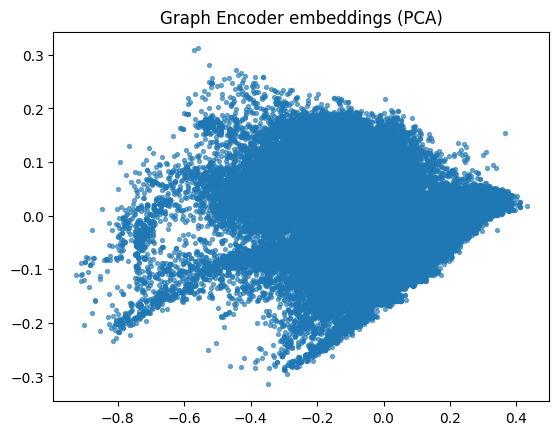

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Combine for visualization
X = np.stack(df_out["graph_emb"].to_numpy())
pca = PCA(2).fit_transform(X)
plt.scatter(pca[:,0], pca[:,1], s=8, alpha=0.6)
plt.title("Graph Encoder embeddings (PCA)")
plt.savefig("plots/graph_encoder_pca.png", dpi=300, bbox_inches="tight")
plt.show()